### Readme
1. 間段的刺激
2. 200Hz


In [1]:
import numpy as np
import pandas as pd
import h5py
import csv
import matplotlib.pyplot as plt
import cv2

from flysimpler import Network
from IPython.display import clear_output

import CRIRELs_plot as cplot

%load_ext autoreload
%autoreload 2

## network

In [2]:
def simulation(group_name, e_bias, i_bias, acc, deltae=0, deltai=0, amp=1, delta=0,  delta_t=0,index_array=(0,0,0)):
    '''
    acc : accuracy
    '''
    b_e1 = round(e_bias, acc)        # bias
    b_e2 = round(e_bias, acc)        # bias
    b_i1 = round(i_bias, acc)        # bias
    b_i2 = round(i_bias, acc)        # bias
    bias_str = "_" + str(b_e1) + "_" + str(b_i1) 
    bias_str =  f"BE={b_e1}, BI={b_i1}, delta={delta}"
    print(f"trial : {bias_str}")
    
    ii, jj, kk = index_array
    
    net = Network()
    # ====================== Generate Conf File =================================
    # (Name, N, C, Taum, RestPot, ResetPot, Threshold)
    for i, neu in enumerate(neu_list):
        net.add_neuron(neu, 1, 
                       neu_c_list[i], 
                       neu_tau_list[i], 
                       neu_rest_list[i], 
                       neu_reset_list[i], 
                       -50, 
                       neu_ref_list[i])
    

    # (Name, Tau, RevPot, FreqExt, MeanExtEff, MeanExtCon)
    net.add_receptor('AMPA', 2, 0, 0, 0 ,0) #10.5 1    #excitatory
    net.add_receptor('GABA', 5, -90, 0, 0, 0)     #inhibitatory
    net.add_receptor('Ach', 20, 0, 0, 3.11, 1)
    net.add_receptor('NMDA', 100, 0, 0, 0, 0)

    net.set_neuron_receptor_all('AMPA')
    net.set_neuron_receptor_all('GABA')
    
    net.add_receptor('AMPA', AMPA, 0, 0, 0, 0)     #excitatory#########################################################
    net.set_neuron_receptor('buffer', 'AMPA')

    # connection
    
    #net.add_target('eo', 'eo', 'AMPA', re_weight, 1)        # recurrent
    # ========== inp1 ========================================
    net.add_target('inp1', 'e1', 'AMPA', inp, 1)     # fixed
    net.add_target('inp1', 'i1', 'AMPA', inp, 1)     # fixed

    # ========== inp2 ========================================
    net.add_target('inp2', 'e2', 'AMPA', inp, 1)     # fixed
    net.add_target('inp2', 'i2', 'AMPA', inp, 1)     # fixed

    # ========== e1 ========================================
    #net.add_target('e1', 'e2', 'AMPA', e1e2, 1)
    #net.add_target('e1', 'i1', 'AMPA', e1i1, 1)
    #net.add_target('e1', 'i2', 'AMPA', e1i2, 1) 
    net.add_target('e1', 'eo', 'AMPA', outp, 1)     # fixed

    # ========== e2 ========================================
    #net.add_target('e2', 'e1', 'AMPA', e2e1, 1)
    #net.add_target('e2', 'i1', 'AMPA', e2i1, 1)
    #net.add_target('e2', 'i2', 'AMPA', e2i2, 1) 
    net.add_target('e2', 'eo', 'AMPA', outp, 1)

    # ========== i1 ========================================
    net.add_target('i1', 'e1', 'AMPA', i1e1, 1)
    net.add_target('i1', 'e2', 'GABA', i1e2, 1)
    #net.add_target('i1', 'i2', 'GABA', i1i2, 1)

    # ========== i2 ========================================
    net.add_target('i2', 'e1', 'GABA', i2e1, 1)
    net.add_target('i2', 'e2', 'AMPA', i2e2, 1)
    #net.add_target('i2', 'i1', 'GABA', i2i1, 1)
    
    # ========== eo ========================================
    #net.add_target('eo', 'buffer', 'AMPA', 100, 1)
    
    #net.plot_network()          #draw connection

    # ====================== Generate Pro File =================================
    Type_Mem = 'ChangeMembraneNoise'
    Type_Freq = 'ChangeExtFreq'
    Type_End = 'EndTrial'
    # ========== time (ms) ===================================
    # (Time, Type, Population, GaussMean, GaussSTD)
    # ========== bias ========================================
    net.add_event(2, Type_Mem, 'buffer', 0.1, 0)
    net.add_event(2, Type_Mem, 'eo', b_eo, 0)
    net.add_event(2, Type_Mem, 'e1', b_e1, 0)
    net.add_event(2, Type_Mem, 'e2', b_e2, 0)
    net.add_event(2, Type_Mem, 'i1', b_i1, 0)
    net.add_event(2, Type_Mem, 'i2', b_i2, 0)
    
    sti_11_1_new = amp 
    sti_10_1_new = amp
    sti_10_0_new = amp
    sig =1
    # ========== (1, 1) ======================================
    net.add_event(time_rest, Type_Mem, 'inp1', sti_11_1_new , sig)
    net.add_event(time_rest, Type_Mem, 'inp2', sti_11_1_new , sig)
    net.add_event(time_rest*1+time_stim*1, Type_Mem, 'inp1', 0 , 0)
    net.add_event(time_rest*1+time_stim*1, Type_Mem, 'inp2', 0 , 0)

    # ========== (1, 0) ======================================
    net.add_event(time_rest*2+time_stim*1, Type_Mem, 'inp1', sti_11_1_new , sig)
    net.add_event(time_rest*2+time_stim*1+delta_t/10., Type_Mem, 'inp2', sti_11_1_new , sig)
    net.add_event(time_rest*2+time_stim*2, Type_Mem, 'inp1', 0 , 0)
    net.add_event(time_rest*2+time_stim*2, Type_Mem, 'inp2', 0 , 0)

    # ========== (0, 1) ======================================
    net.add_event(time_rest*3+time_stim*2+delta_t/10., Type_Mem, 'inp1', sti_11_1_new , sig)
    net.add_event(time_rest*3+time_stim*2, Type_Mem, 'inp2', sti_11_1_new , sig)
    net.add_event(time_rest*3+time_stim*3, Type_Mem, 'inp1', 0 , 0)
    net.add_event(time_rest*3+time_stim*3, Type_Mem, 'inp2', 0 , 0)
    
    # ========== (0, 0) ======================================
    net.add_event(time_rest*4+time_stim*3, Type_Mem, 'inp1', 0 , 0)
    net.add_event(time_rest*4+time_stim*3+delta_t/10., Type_Mem, 'inp2', 0 , 0)
    net.add_event(time_rest*4+time_stim*4, Type_Mem, 'inp1', 0 , 0)
    net.add_event(time_rest*4+time_stim*4, Type_Mem, 'inp2', 0 , 0)
    
    # ========== (1, 1) ======================================
    #net.add_event(time_rest*5+time_stim*4, Type_Mem, 'inp1', sti_11_1_new , 0)
    #net.add_event(time_rest*5+time_stim*4+delta_t/10., Type_Mem, 'inp2', sti_11_1_new , 0)
    #net.add_event(time_rest*5+time_stim*5, Type_Mem, 'inp1', 0 , 0)
    #net.add_event(time_rest*5+time_stim*5, Type_Mem, 'inp2', 0 , 0)

    # ========== end ======================================
    net.add_event(time_rest*4+time_stim*4+100, Type_End)
    # (Filename, Type, Population, *args)
    net.add_output('MemPot.dat'  , 'MemPot', 'AllPopulation')
    net.add_output('SpikeALL.dat', 'Spike', 'AllPopulation')
    net.add_output('FiringRateALL.dat', 'FiringRate', 'AllPopulation', 50, 10)


    
    
    # ====================== Output File =================================
    net.output('network.conf', 'network.pro')
    # ====================== simulation =================================
    !/media/alexander/9e1069d5-cd39-4e83-8eff-49b4335462dd/home/ns-cclolab/Documents/ALEX_0605-20230605T073644Z-001/ALEX_0605/LIF_Logic/flysim07_21_2.out -conf network.conf -pro network.pro -nmodel LIF


    # ====================== save data =================================
#     m_data = pd.read_csv('MemPot.dat', delim_whitespace=True, names=['time']+list(neu_list)).to_numpy()
#     try:
#         m_dset = group_para.create_dataset(bias_str+"_mem_dataset", m_data.shape, dtype='f')
#         m_dset[:,:] = m_data
#     except:
#         print("data already exist")
#         m_dset = group_para[bias_str+"_mem_dataset"]
#         m_dset[:,:] = m_data

    f_data = pd.read_csv('FiringRateALL.dat', delim_whitespace=True, names=['time']+list(neu_list)).to_numpy()
    g_data = pd.read_csv('MemPot.dat', delim_whitespace=True, names=['time']+list(neu_list)).to_numpy()
#     try:
#         f_dset = group_para.create_dataset(bias_str+"_fra_dataset", f_data.shape, dtype='f')
#         f_dset[:,:] = f_data
#     except:
#         f_dset = group_para[bias_str+"_fra_dataset"]
#         f_dset[:,:] = f_data

    
    df = pd.DataFrame(f_data, columns=['time']+list(neu_list))
    dg = pd.DataFrame(g_data, columns=['time']+list(neu_list))
    
    outname = f"e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    outnameg = f"V_e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    outnamege = f"Ve_e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    outnamegi = f"Vi_e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    outnamege2 = f"Ve2_e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    outnamegi2 = f"Vi2_e_{ii:03d}_i_{jj:03d}_k_{kk:03d}"
    df['eo'].to_csv("feedforward_temp"+"/"+ outname, index=False, sep='\t')
    dg['eo'].to_csv("feedforward_temp_V"+"/"+ outnameg, index=False, sep='\t')
    dg['e1'].to_csv("feedforward_temp_V"+"/"+ outnamege, index=False, sep='\t')
    dg['i1'].to_csv("feedforward_temp_V"+"/"+ outnamegi, index=False, sep='\t')
    dg['e2'].to_csv("feedforward_temp_V"+"/"+ outnamege2, index=False, sep='\t')
    dg['i2'].to_csv("feedforward_temp_V"+"/"+ outnamegi2, index=False, sep='\t')
    
    clear_output() # 清除輸出
    

## h5py

In [3]:
def gen_file(b_eo, c=0.5, tau=20, rest=-70, reset=-55, ref=5, AMPA=2, weight=50, gee =30, gei = 30, gie = 60, gii =30):
    
    h5_path = "result/"
    fname = str(b_eo)+"_"+str(c)+"_"+str(tau)+"_"+str(rest)+"_"+str(reset)+"_"+str(ref)+ "_"+str(AMPA) + "_"+str(weight)
    paras = [b_eo, c, tau, rest, reset, ref, AMPA, weight]
    
    
    # =============== open file and group ================================
    f_h5py = h5py.File(h5_path+fname, 'a') 
    group_name = "version_01"
    try :
        logic_para = f_h5py.create_group(group_name+'_group')     # create group
        print(f"create new group : {group_name}")
    except:
        logic_para = f_h5py[group_name+'_group']                  # open group
        print(f"open old group : {group_name}")
    
    
    ## population 
    logic_para.attrs['neu_list']       = ['inp1', 'inp2', 'e1', 'e2', 'i1', 'i2',  'eo', 'buffer']
    logic_para.attrs['neu_c_list']     = [  0.5,     0.5,  0.5,  0.5,  0.5,  0.5,   0.5,      0.5]
    logic_para.attrs['neu_tau_list']   = [   20,      20,   20,   20,   20,   20,    20,       20]
    logic_para.attrs['neu_rest_list']  = [  -70,     -70,  -70,  -70,  -70,  -70,  rest,      -70]
    logic_para.attrs['neu_reset_list'] = [  -55,   -55,  -55,  -55,  -55,  -55, reset,    -50.1]
    logic_para.attrs['neu_ref_list']   = [  ref,     ref,   -1,   -1,   -1,   -1,   ref,      ref]


    #logic_para.attrs['re_weight'] = 100

    logic_para.attrs['c'] = c
    logic_para.attrs['tau'] = tau
    logic_para.attrs['rest'] = rest
    logic_para.attrs['reset'] = reset
    logic_para.attrs['ref'] = ref
    logic_para.attrs['AMPA'] = AMPA

    ## weight
    wee = gee
    logic_para.attrs['e1e2'] = 0   # e1
    logic_para.attrs['e1i1'] = 0
    logic_para.attrs['e1i2'] = 0
    logic_para.attrs['e2e1'] = 0    # e2
    logic_para.attrs['e2i1'] = 0
    logic_para.attrs['e2i2']  =0
    logic_para.attrs['i1e1'] = gie   # i1
    logic_para.attrs['i1e2'] = gii
    logic_para.attrs['i1i2'] = 0
    logic_para.attrs['i2e1'] = gii    # i2
    logic_para.attrs['i2e2'] = gie
    logic_para.attrs['i2i1'] = 0

    logic_para.attrs['inp'] = 45
    logic_para.attrs['outp'] = weight                   #output weight

    logic_para.attrs['b_eo'] = bias
    logic_para.attrs['b_e1'] = 0
    logic_para.attrs['b_e2'] = 0
    logic_para.attrs['b_i1'] = 0
    logic_para.attrs['b_i2'] = 0

    logic_para.attrs['sti_11_1'] = 10
    logic_para.attrs['sti_10_1'] = 10
    logic_para.attrs['sti_10_0'] = 10

    logic_para.attrs['time_stim'] = 400*2
    logic_para.attrs['time_rest'] = 400*2

    f_h5py.close()
    
    return h5_path, fname, group_name, paras

def read_parameter(h5_path, fname, group_name):
    f_h5py = h5py.File(h5_path+fname, 'r')
    group_para= f_h5py[group_name+"_group"]          # open group

    for k in group_para.attrs.keys():
        globals()[k] = group_para.attrs[k]
        print(f'{k} => {group_para.attrs[k]}')
    
    clear_output() # 清除輸出
    print(f"open {fname}, and read parameter")
    f_h5py.close()

# simulation

In [4]:
###CORRECT ##
###
###
####CORRECT###
# e_bias = 0.65
# i_bias = 0.15
# tit="XNOR"
and_gate  = (0.4, -.3, "AND", 0, 0)
nand_gate = (0.7, 1.0, "NAND", 0, 0)
or_gate   = (0.4, -0.8, "OR", 0, 0)
nor_gate  = (0.6, 0.35, "NOR", 0, 0)
xor_gate  = (1.0, 1.8, "XOR", 0, 0)
xnor_gate = (0.6, 0.1, "XNOR", 0, 0)
imply_gate = (0.8, 1.4, "IMPLY", 0, 0.6)
nimply_gate = (0.5, 1.0, "NIMPLY", 0.3, 0)

gate_tuple = (and_gate, nand_gate, or_gate, nor_gate, xor_gate, xnor_gate, imply_gate, nimply_gate)
gate_tuple = ((0.4, -1.3,"custom",0,0), )
gate_NAME = "or"
step = 2. 
amp = 24
delta = 5 
delta_t = 100 
gee = 30
e_bias_list = np.arange(-1, 3, .25) # -0.5, 1.5, 0.05  # 0.5, 0.75
i_bias_list = np.arange(-1, 5, .25) # -1.2, 2.2, 0.05  # 0.0, 0.50
gee_list    = np.arange(30,60,6)

for kk, gii in enumerate(gee_list):
    for ii, e_b in enumerate(e_bias_list):
        for jj, i_b in enumerate(i_bias_list):
            #e_bias, i_bias, tit, deltae, deltai = gate
            tit="unk"
            deltae = 0
            deltai = 0 
            e_bias= e_b
            i_bias =i_b
                # ================ parameter ================
            bias  = .5
            c     = 0.5
            tau   = 20
            rest  = -70
            reset = -55
            ref   = 5
            AMPA  = 20
            weight= 50

            # ================ generate ================
            h5_path, fname, group_name, paras = gen_file(bias, c, tau, rest, reset, ref, AMPA, weight, 0,0,30,gii)

            # ================ read ================
            read_parameter(h5_path, fname, group_name)  

            f_h5py = h5py.File(h5_path+fname, 'r+')
            group_para= f_h5py[group_name+"_group"]          # open group


            # ================ parameter ================
            # e_bias = 0.65
            # i_bias = 0.25
            index_array = (ii, jj, kk)
            print(index_array)
            simulation(group_name, e_bias, i_bias, 2, deltae, deltai, amp/20., delta/20.,delta_t,index_array)

            # ================ h5py ================
            f_h5py.close()
        
#         # plot =============================================
#         for gate in gate_tuple:
#             e_bias, i_bias, tit, deltae, deltai = gate

#             # ================ plot ================
#             b_e1 = round(e_bias, 2)        # bias
#             b_i1 = round(i_bias, 2)        # bias
#             bias_str = "_" + str(b_e1) + "_" + str(b_i1)

#             file_para = [h5_path, fname, group_name]
#             f_df, neu_list = cplot.read_f_data(file_para, bias_str)
#             m_df, f_df, neu_list = cplot.read_all_data(file_para, bias_str)

#             m_df = m_df[m_df["time"]<3.6]
#             f_df = f_df[f_df["time"]<3.6]

#             cplot.plot_single_FR_nofname(b_eo, f_df, fname, bias_str, tit=tit)
#         #     cplot.plot_single_FR(b_eo, f_df, fname, bias_str, tit=tit)
#         #     cplot.plot_single_Mem_FR(b_eo, m_df, f_df, fname, bias_str, tit=tit)
#             outname = "amp"+str(amp)+"_delta"+str(delta)+".dat"

In [12]:

# e_bias = 0.65
# i_bias = 0.15
# tit="XNOR"
and_gate  = (0.4, -.3, "AND", 0, 0)
nand_gate = (0.7, 1.0, "NAND", 0, 0)
or_gate   = (0.4, -0.8, "OR", 0, 0)
nor_gate  = (0.6, 0.35, "NOR", 0, 0)
xor_gate  = (1.0, 1.8, "XOR", 0, 0)
xnor_gate = (0.6, 0.1, "XNOR", 0, 0)
imply_gate = (0.8, 1.4, "IMPLY", 0, 0.6)
nimply_gate = (0.5, 1.0, "NIMPLY", 0.3, 0)

gate_tuple = (and_gate, nand_gate, or_gate, nor_gate, xor_gate, xnor_gate, imply_gate, nimply_gate)
gate_tuple = ((0.4, -1.3,"custom",0,0), )
gate_NAME = "or"
step = 2. 
# for amp in range(0,160,8):
#     for delta in range(0,20,1):
for gate in gate_tuple:
    e_bias, i_bias, tit, deltae, deltai = gate
    # ================ parameter ================
    bias  = 0
    c     = 0.5
    tau   = 20
    rest  = -70
    reset = -55
    ref   = 5
    AMPA  = 20
    weight= 50

    # ================ generate ================
    h5_path, fname, group_name, paras = gen_file(bias, c, tau, rest, reset, ref, AMPA, weight)

    # ================ read ================
    read_parameter(h5_path, fname, group_name)  

    f_h5py = h5py.File(h5_path+fname, 'r+')
    group_para= f_h5py[group_name+"_group"]          # open group


    # ================ parameter ================
    # e_bias = 0.65
    # i_bias = 0.25

    simulation(group_name, e_bias, i_bias, 2, deltae, deltai, amp/20., delta/20.,index_array)

    # ================ h5py ================
    f_h5py.close()

#         # plot =============================================
#         for gate in gate_tuple:
#             e_bias, i_bias, tit, deltae, deltai = gate

#             # ================ plot ================
#             b_e1 = round(e_bias, 2)        # bias
#             b_i1 = round(i_bias, 2)        # bias
#             bias_str = "_" + str(b_e1) + "_" + str(b_i1)

#             file_para = [h5_path, fname, group_name]
#             f_df, neu_list = cplot.read_f_data(file_para, bias_str)
#             m_df, f_df, neu_list = cplot.read_all_data(file_para, bias_str)

#             m_df = m_df[m_df["time"]<3.6]
#             f_df = f_df[f_df["time"]<3.6]

#             cplot.plot_single_FR_nofname(b_eo, f_df, fname, bias_str, tit=tit)
#         #     cplot.plot_single_FR(b_eo, f_df, fname, bias_str, tit=tit)
#         #     cplot.plot_single_Mem_FR(b_eo, m_df, f_df, fname, bias_str, tit=tit)
#             outname = "amp"+str(amp)+"_delta"+str(delta)+".dat"

open 0_0.5_20_-70_-55_5_20_50, and read parameter
trial : BE=0.4, BI=-1.3, delta=0.25


TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

In [57]:
f_df["eo"].to_csv('data.txt', index=False, sep='\t')

In [14]:
group_name=""
e_bias = 0.4
i_bias = -0.3
deltae = 0
deltai=0
simulation(group_name, e_bias, i_bias, 2, deltae, deltai, 1, 0)

trial : _0.4_-0.3


NameError: name 'neu_list' is not defined

# plot stimulus

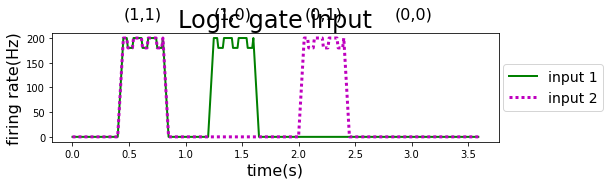

In [47]:
FZ = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 2), sharex=True)
ax.plot(f_df['time'], f_df['inp1'], color='g', lw=2, label='input 1')
ax.plot(f_df['time'], f_df['inp2'], color='m', dashes=[1, 1], lw=3, label='input 2')


ax.set_title("Logic gate input" , fontsize=FZ+8)
ax.set_xlabel("time(s)" , fontsize=FZ)
ax.set_ylabel("firing rate(Hz)" , fontsize=FZ)



# ax.set_ylim([-20,300])
# ax.set_yticks([0,200],["0", "200"])

ax.text(0.45, 240, "(1,1)", fontsize=FZ)
ax.text(1.25, 240, "(1,0)", fontsize=FZ)
ax.text(2.05, 240, "(0,1)", fontsize=FZ)
ax.text(2.85, 240, "(0,0)", fontsize=FZ)

ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=FZ-2)

In [49]:
max(f_df['inp2'])

200.0

# plot phase

In [77]:
# single sweep
bias  = -0.1
c     = 0.5
tau   = 20
rest  = -70
reset = -55
ref   = 5
AMPA  = 20
weight= 50


# ================ generate ================
h5_path, fname, group_name, paras = gen_file(bias, c, tau, rest, reset, ref, AMPA, weight)

# ================ read ================
read_parameter(h5_path, fname, group_name)  

f_h5py = h5py.File(h5_path+fname, 'r+')
group_para= f_h5py[group_name+"_group"]          # open group

# sweep simulation
# ====================== Generate network all=================================
e_bias_list = np.arange(0, 2, .5) # -0.5, 1.5, 0.05  # 0.5, 0.75
i_bias_list = np.arange(0, 1, 0.5) # -1.2, 2.2, 0.05  # 0.0, 0.50

for amp in e_bias_list:
    for delta in i_bias_list: 
        h5_path, fname, group_name, paras = gen_file(bias, c, tau, rest, reset, ref, AMPA, weight,onne =amp,zerro=amp*delta)
        print(f"{bias}, {AMPA}, {weight}")
        simulation(group_name,-.4, -3, 2)


# ================ h5py ================
f_h5py.close()
print("finish")

finish


In [78]:
# single sweep
bias  = -0.1
c     = 0.5
tau   = 20
rest  = -70
reset = -55
ref   = 5
AMPA  = 20
weight= 50


h5_path, fname, group_name, paras = gen_file(bias, c, tau, rest, reset, ref, AMPA, weight)

file_para = [h5_path, fname, group_name]
cplot.phase(file_para,[0, 2, 0,1], 0.5)
#cplot.phase_single(file_para,[0.5, 0.7, -1.2, -1], 0.05)

open old group : version_01
1


KeyError: "Unable to open object (object '_0.0_0.0_fra_dataset' doesn't exist)"